In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

<h3>Keras models and training</h3>

API documentation homepage: https://www.tensorflow.org/api_docs/python/tf?hl=en

Intro to Keras tutorial: https://www.tensorflow.org/tutorials/keras/classification (with 'fashion MNIST' below)

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [4]:
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
fashion_train_images = fashion_train_images/255
fashion_test_images = fashion_test_images/255

The following constructs a feed-forward ('sequential') network with some specified layers. Keras' Dense layer is a fully-connected layer; that is, each of its units (neurons) sees every output from the previous layer.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=en

ReLU is probably the most popular activation function at this time, and there may be some theoretical reasons supporting this. tanh is another option; it's simply the logistic function (Keras: 'sigmoid') with its values symmetrised, so that tanh(x) lies between -1 and 1, and tanh(0) = 0. There are others that have been used. If the layer is not given an activation argument, then its output is simply a linear transformation of its inputs (that is, the activation function is the identity f(x) = x).

In [6]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape = (28,28)),  # Dense expects 1D input
                            tf.keras.layers.Dense(128, activation='relu'), 
                            tf.keras.layers.Dense(10),
                            tf.keras.layers.Softmax()])

In [7]:
# if you want to leave out the Softmax layer above, add argument from_logits=True to the loss function here. I don't know
# whether it makes any difference.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
# the default batch_size is 32
model.fit(fashion_train_images, fashion_train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4972 - accuracy: 0.8250
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3709 - accuracy: 0.8668
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3336 - accuracy: 0.8775
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3101 - accuracy: 0.8868
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2926 - accuracy: 0.8917
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2780 - accuracy: 0.8969
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2646 - accuracy: 0.9013
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2522 - accuracy: 0.9062
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2460 - accuracy: 0.9090
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.234

In [9]:
# score the model on the held-out set
test_loss, test_acc = model.evaluate(fashion_test_images,  fashion_test_labels, verbose=2)

313/313 - 0s - loss: 0.3370 - accuracy: 0.8834 - 412ms/epoch - 1ms/step


In [10]:
predictions=model.predict(fashion_test_images)

313/313 [==============================] - 0s 808us/step


In [12]:
# if you want to take a closer look...
pred_df = pd.DataFrame(predictions)
pred_df['choice'] = pred_df.apply(np.argmax, axis=1)
pred_df['real'] = fashion_test_labels
errors = pred_df.loc[pred_df.choice != pred_df.real]

The next few cells are some plotting routines from the tutorial to visualise some of the results given by the model.

In [13]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
for i in range(0,13):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], fashion_test_labels, fashion_test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  fashion_test_labels)
    plt.show()

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], fashion_test_labels, fashion_test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], fashion_test_labels)
plt.tight_layout()
plt.show()

<h3>Keras Hyperparameters Tuner</h3>

With a vast number of possible model configurations and hyperparameters it can be tedious and discouraging to try to explore the permutations manually. KerasTuner takes in a recipe, with specified variables, for making a model and tries out variations. 

The recipe is given a Hyperparameters object, which contains various methods that tell the tuner what data type and allowed values a given variable has. In the example below, the hp.Int() method creates an integer variable ranging from 32 to 512 in steps of 32. The method hp.Choice() can be used for categorical choices or numerical choices with irregular spacing. It simply takes in a list of allowed values from which the tuner will choose. There are a few more such methods. The first argument to each of these methods is a string giving the name the variable will get when the tuner makes its reports.

KerasTuner API: https://keras.io/api/keras_tuner/
KerasTuner tutorial: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=en (again with 'fashion MNIST' below)

Hyperparameters doc: https://keras.io/api/keras_tuner/hyperparameters

In [17]:
import keras_tuner as kt

In [18]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

KerasTuner has a few discrete search routines to explore the hyperparameter space you defined: random search, Bayesian optimisation, and an algorithm called Hyperbandit. The tutorial uses Hyperbandit.

The arguments <i>directory</i> and <i>project_name</i> below will save everything the model does to disk. They can be omitted. As a caution, the saved data may take up a lot of space as the size of the NN tested grows. I assume this happens because it's saving network weights to disk, but I haven't been able to figure out how to retrieve them. It probably does not matter.

Tuner docs: https://keras.io/api/keras_tuner/tuners/

In [19]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Here is a <b>warning</b>: the tutorial (on the webpage) passes an argument <i>validation_split</i> to the tuner search below. One may suppose this means the tuner will make a split of the data given to it. It does <i>not</i> do so; it appears that actually the keyword is undefined here. By default the tuner simply uses the training data given to it to compute its "validation" statistics. The correct way to specify validation data for the search is to pass a pair

    validation_data = (val_features, val_labels)
    
In this example we'll just use the test set already provided. As a reminder, for real applications we must make a split within the training data for this. The alternative is to invite overfitting hyperparameters.

In [21]:
# the callback here will automatically end the search if its condition is met, that a model does not improve its loss
# on the validation set after a set number of training epochs. You can also end it mid-search by interrupting the python 
# kernel; it retains the results up to that time.
tuner.search(fashion_train_images, fashion_train_labels, 
             validation_data = (fashion_test_images, fashion_test_labels), 
             callbacks=[stop_early])

Trial 30 Complete [00h 00m 31s]
val_accuracy: 0.8830999732017517

Best val_accuracy So Far: 0.8830999732017517
Total elapsed time: 00h 07m 05s
INFO:tensorflow:Oracle triggered exit


Passing an integer to the Tuner method .get_best_hyperparameters() will give you that many of the top results encountered during the search. For the Bayes search this does not appear to be helpful. This is because essentially it tries to fine-tune the hyperparameters by looking at a lot of models around where it gets good results. Consequently, the top entries of this list may be very close or even identical. Hyperbandit is slightly better in this regard, since its algorithm also tries to explore new parts of the hyperparameter space.

In any case, the method .results_summary() will print a bunch of the top models. This summary also includes their scores on the search objective (here, <i>val_accuracy</i>).

Of course, there is no guarantee that the search will actually find any or all of the "best" models. More, the result of training them depends on their random weight initialisation. The tuner just tries things and reports on them.

In [22]:
best_hps=tuner.get_best_hyperparameters()[0]
# tuner.get_best_hyperparameters()[0].values gives you the underlying dict, with keys the variable names you chose.

In [23]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal learning rate for the optimizer
is 0.001.



In [24]:
# For the model method .fit() the validation_split argument does what it's supposed to.
model = tuner.hypermodel.build(best_hps)
history = model.fit(fashion_train_images, fashion_train_labels, epochs=50, validation_split=0.2)

Epoch 1/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5144 - accuracy: 0.8209 - val_loss: 0.4043 - val_accuracy: 0.8538
Epoch 2/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3835 - accuracy: 0.8621 - val_loss: 0.3673 - val_accuracy: 0.8690
Epoch 3/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3439 - accuracy: 0.8739 - val_loss: 0.3462 - val_accuracy: 0.8768
Epoch 4/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3146 - accuracy: 0.8823 - val_loss: 0.3354 - val_accuracy: 0.8813
Epoch 5/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2954 - accuracy: 0.8907 - val_loss: 0.3326 - val_accuracy: 0.8819
Epoch 6/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2821 - accuracy: 0.8963 - val_loss: 0.3444 - val_accuracy: 0.8775
Epoch 7/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2710 - accuracy: 0.8989 - val_loss: 0.3356 - val_accuracy:

In [25]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 22


In [ ]:
# you can fill up the screen with output doing this and find similar results
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(fashion_train_images, fashion_train_labels, epochs=best_epoch, validation_split=0.2)

In [28]:
# after using a subset of the training data to try to compare and optimise hyperparameter choices, there is the 'original' 
# test set to validate, or not, the results.
test_loss, test_acc = model.evaluate(fashion_test_images, fashion_test_labels, verbose=2)

313/313 - 0s - loss: 0.5449 - accuracy: 0.8864 - 404ms/epoch - 1ms/step


<h3>Model testing: Convolution blocks and regularisation methods</h3>

Below: trying out the API etc with the garg data set.

Convolution layer docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?hl=en

In [29]:
train_garg = pd.read_csv("sign_mnist_train.csv")
test_garg = pd.read_csv("sign_mnist_test.csv")

In [30]:
train_garg_square = train_garg.drop('label',axis=1).to_numpy().reshape((27455, 28, 28))
test_garg_square = test_garg.drop('label',axis=1).to_numpy().reshape((7172,28,28))

train_garg_square = np.float32(train_garg_square) / 255
test_garg_square = np.float32(test_garg_square) / 255

train_garg_labels = train_garg['label'].to_numpy()
test_garg_labels = test_garg['label'].to_numpy()

The Hyperparameters method .conditional_scope() allows parts of the recipe to depend on earlier choices. 

In [122]:
def conv_model_builder(hp):
    f_min, f_max, f_step = 8, 128, 8
    layers_min, layers_max = 1, 4
     
    hp_filters = []
    hp_rec_fields = []
    hp_padding = []
    hp_use_bias = []
    hp_layers = hp.Int('conv_layers', min_value = layers_min, max_value = layers_max)
    
    model = tf.keras.Sequential()          
    for i in range(0, hp_layers):
        """ 
    I think the intended correct way to do this is to have the following in a code block starting
        with hp.conditional_scope('conv_layers', list(range(0, hp_layers))):
    but that raises an exception: 
        NotImplementedError:
        Lists of stacks of conditions used during `explore_space()`.
    Without conditional_scope when hp_layers < layers_max the tuner still chooses values for the variables in the 
    iterations of this loop that aren't triggered (it doesn't display them during the search process, but see the model
    in the results_summary below with score 0.6954), and consequently treats as different instances of the same model. 
    Aside from being a waste of time, this may not interact well with the Hyperbandit algorithm.
    """
        hp_filters.append(hp.Int('conv_filters_' + str(i), min_value = f_min, max_value = f_max, step = f_step))
        hp_rec_fields.append(hp.Choice('rec_field_' + str(i), values = [3,5]))
        hp_padding.append(hp.Choice('padding_' + str(i), values=['same','valid']))
        hp_use_bias.append(hp.Boolean('use_bias_' + str(i)))
        model.add(tf.keras.layers.Convolution2D(hp_filters[i], 
                                                hp_rec_fields[i], 
                                                padding=hp_padding[i], 
                                                use_bias=hp_use_bias[i],
                                                input_shape = (28,28,1),
                                                activation='tanh'))
        # actually, the input_shape is only (28,28,1) for the bottom layer; I'm not sure why this syntax works, but
        # it's possible (given how the documentation is worded) that this argument is just ignored in the later layers
    model.add(tf.keras.layers.Flatten())
    #hp_units = hp.Int('proj_dim', min_value=32, max_value=512, step=32)
    #model.add(tf.keras.layers.Dense(units=hp_units))                       # linear projection layer
    model.add(tf.keras.layers.Dense(25, activation='softmax'))   # output layer
    
    # the optimiser is part of the hypermodel too
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [ ]:
# According to the documentation, a Hyperband search "will run approximately max_epochs * (math.log(max_epochs, factor) ** 2) 
# cumulative epochs across all trials." 
conv_tuner_hypband = kt.Hyperband(conv_model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3)

# since this dataset has 25 labels, uniform random guessing scores 0.04. this first callback is supposed to have the tuner 
# discard a model if it does not get at least 5% accuracy on the validation data (it happens from time to time that a model 
# gets stuck at the mean, effectively guessing each label with its frequency in the set, a bad local minimum). however, I'm 
# not altogether certain if/how it works. I do know that patience=0 does not do what I think it should.
stop_failed = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.05, patience=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callbacks = [stop_failed, stop_early]

In [64]:
conv_tuner_hypband.search(train_garg_square, train_garg_labels, 
                          validation_data=(test_garg_square, test_garg_labels), 
                          callbacks=callbacks)

Trial 30 Complete [00h 06m 56s]
val_accuracy: 0.6655047535896301

Best val_accuracy So Far: 0.7143056392669678
Total elapsed time: 02h 13m 21s
INFO:tensorflow:Oracle triggered exit


Here are some results from an earlier iteration of this code which had better luck (and <i>max_layers</i> set to 3). The results were mixed, but they did agree on one thing: the learning rate they used was the least one of the options. So, in later experiments I let it go a bit lower. Needless to add, whatever conclusions I draw will be applicable at most to the current context: these models, this dataset.

In [59]:
conv_tuner_hypband.results_summary()

Results summary
Results in my_dir\intro_to_kt
Showing 10 best trials
Trial summary
Hyperparameters:
conv_filters_0: 48
recField_0: 5
padding_0: valid
useBias_0: True
conv_layers: 3
units: 192
learning_rate: 0.0001
conv_filters_1: 120
recField_1: 3
padding_1: valid
useBias_1: True
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
conv_filters_2: 8
recField_2: 3
padding_2: same
useBias_2: False
tuner/trial_id: 0012
Score: 0.745398759841919
Trial summary
Hyperparameters:
conv_filters_0: 48
recField_0: 5
padding_0: valid
useBias_0: True
conv_layers: 3
units: 192
learning_rate: 0.0001
conv_filters_1: 120
recField_1: 3
padding_1: valid
useBias_1: True
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
conv_filters_2: 8
recField_2: 3
padding_2: same
useBias_2: False
tuner/trial_id: 0003
Score: 0.7380089163780212
Trial summary
Hyperparameters:
conv_filters_0: 48
recField_0: 5
padding_0: valid
useBias_0: True
conv_layers: 3
units: 192
learning_rate: 0.0

In [68]:
conv_tuner_bayes.results_summary()

Results summary
Results in my_dir\intro_to_kt2
Showing 10 best trials
Trial summary
Hyperparameters:
conv_filters_0: 128
recField_0: 3
padding_0: same
useBias_0: False
conv_layers: 3
units: 224
learning_rate: 0.0001
conv_filters_1: 128
recField_1: 5
padding_1: valid
useBias_1: True
conv_filters_2: 8
recField_2: 5
padding_2: valid
useBias_2: True
Score: 0.7691020369529724
Trial summary
Hyperparameters:
conv_filters_0: 128
recField_0: 3
padding_0: same
useBias_0: False
conv_layers: 3
units: 256
learning_rate: 0.0001
conv_filters_1: 128
recField_1: 5
padding_1: valid
useBias_1: True
conv_filters_2: 8
recField_2: 5
padding_2: valid
useBias_2: True
Score: 0.7639431357383728
Trial summary
Hyperparameters:
conv_filters_0: 128
recField_0: 3
padding_0: same
useBias_0: False
conv_layers: 3
units: 256
learning_rate: 0.0001
conv_filters_1: 128
recField_1: 5
padding_1: valid
useBias_1: True
conv_filters_2: 8
recField_2: 5
padding_2: valid
useBias_2: True
Score: 0.7607361674308777
Trial summary
Hype

Here's a later experiment looking at the effectiveness of a few regularisation methods, $L^2$ loss penalty and unit dropout. Actually the most significant change from above was the addition of a few pooling layers.

In [170]:
def conv_model_builder_mk6(hp):
    f_min, f_max, f_step=16, 256, 16
    reg_coef = hp.Float('decay', min_value=0.05, max_value=0.15, step=0.01)
    dropout_prob = hp.Float('dropout', min_value = 0.1, max_value = 0.5, step = 0.1)
    regulator = tf.keras.regularizers.L2(reg_coef)
    hp_filters, hp_rec_fields = [],[]
    hp_units = hp.Int('units', min_value=64, max_value = 512, step=32)
    for i in range(0,4):
        hp_filters.append(hp.Int('conv_filters_' + str(i), min_value = f_min, max_value = f_max, step = f_step))
        hp_rec_fields.append(hp.Choice('rec_field_' + str(i), values = [3,5]))
    model = tf.keras.Sequential([tf.keras.layers.Convolution2D(hp_filters[0], hp_rec_fields[0], activation='relu', 
                                                               padding='same', use_bias = True,
                                            input_shape = (128,128,3), kernel_regularizer=regulator),
                                 tf.keras.layers.Dropout(dropout_prob),
                                 tf.keras.layers.Convolution2D(hp_filters[1], hp_rec_fields[1], activation='relu', 
                                                               padding='same', use_bias = True,
                                                              kernel_regularizer=regulator),
                                 tf.keras.layers.MaxPool2D(strides=(2,2)), # default pool size (2,2); cuts down to 14x14x120
                                 tf.keras.layers.Convolution2D(hp_filters[2], hp_rec_fields[2], activation='relu', 
                                                               padding='same', use_bias = True,
                                                              kernel_regularizer=regulator),
                                 tf.keras.layers.Dropout(dropout_prob),
                                 tf.keras.layers.Convolution2D(hp_filters[3], hp_rec_fields[3], activation='relu', 
                                                               padding='same', use_bias = True,
                                                              kernel_regularizer=regulator),
                                 tf.keras.layers.MaxPool2D(strides=(2,2)), # cuts down to 7x7x96
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(hp_units, activation='relu'),
                                 tf.keras.layers.Dropout(dropout_prob),
                                 tf.keras.layers.Dense(76, activation='softmax', kernel_regularizer=regulator)])
                                 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [161]:
conv_tuner_hypband_6 = kt.Hyperband( conv_model_builder_mk6,
                                     objective='val_accuracy',
                                     max_epochs=20,
                                     factor=3,
                                     overwrite=True)

In [162]:
conv_tuner_hypband_6.search(train_garg_square, train_garg_labels, validation_data=(test_garg_square, test_garg_labels), callbacks=[stop_early, stop_failed])

Trial 27 Complete [00h 37m 02s]
val_accuracy: 0.5737590789794922

Best val_accuracy So Far: 0.8753485679626465
Total elapsed time: 11h 42m 52s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
0.14              |0.06              |decay
0.4               |0.2               |dropout
320               |224               |units
80                |64                |conv_filters_0
3                 |5                 |rec_field_0
80                |240               |conv_filters_1
3                 |5                 |rec_field_1
192               |48                |conv_filters_2
5                 |3                 |rec_field_2
144               |96                |conv_filters_3
5                 |5                 |rec_field_3
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/20
531/858

KeyboardInterrupt: 

In [85]:
conv_tuner_hypband_4.results_summary()

Results summary
Results in my_dir\intro_to_kt7
Showing 10 best trials
Trial summary
Hyperparameters:
decay: 0.01
dropout: 0.30000000000000004
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.9037925004959106
Trial summary
Hyperparameters:
decay: 0.01
dropout: 0.1
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0035
Score: 0.9022588133811951
Trial summary
Hyperparameters:
decay: 0.01
dropout: 0.2
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8987730145454407
Trial summary
Hyperparameters:
decay: 0.01
dropout: 0.30000000000000004
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0024
Score: 0.8943111896514893
Trial summary
Hyperparameters:
decay: 0.01
dropout: 0.30000000000000004
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0036
Score: 0.8933351635932922
Trial summary
Hyperparameters

I was surprised at how poorly the early models generalised to the test set, compared to the training set, where they frequently got accuracy between 0.98 and 1 after just a few epochs. Eventually I tried making a test/train split just within the "sign_mnist_train" dataset; on this split the model's accuracy was the same on both parts. Then I tried mixing the two "sign_mnist" datasets and making a different test/train split from it, with the same result. Evidently the dataset author did do something different in processing their test image set, which they did not mention. I have mixed feelings about this.

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
mixed_temp = pd.concat([train_garg, test_garg], ignore_index=True)
print(mixed_temp.shape)

(34627, 785)


In [90]:
train_temp, test_temp = train_test_split(mixed_temp)

train_temp_square = train_temp.drop('label',axis=1).to_numpy().reshape((train_temp.shape[0], 28, 28))
test_temp_square = test_temp.drop('label',axis=1).to_numpy().reshape((test_temp.shape[0],28,28))

train_temp_square = np.float32(train_temp_square) / 255
test_temp_square = np.float32(test_temp_square) / 255

train_temp_labels = train_temp['label'].to_numpy()
test_temp_labels = test_temp['label'].to_numpy()

In [96]:
model = conv_model_builder_mk4(conv_tuner_hypband_4.get_best_hyperparameters()[0])

In [97]:
epochs = 5
for i in range(0,epochs):
    model.fit(train_temp_square, train_temp_labels, epochs = 1)
    model.evaluate(test_temp_square, test_temp_labels, verbose=2)
    
# val_acc reported is larger than immediately preceding acc on the training set because the latter is some kind of 
# average over the training epoch, while the former is computed only from the model at the epoch's end

812/812 [==============================] - 158s 193ms/step - loss: 3.8487 - accuracy: 0.5992
271/271 - 12s - loss: 2.1316 - accuracy: 0.8798 - 12s/epoch - 45ms/step
812/812 [==============================] - 159s 195ms/step - loss: 1.5749 - accuracy: 0.9254
271/271 - 12s - loss: 1.0721 - accuracy: 0.9876 - 12s/epoch - 46ms/step
812/812 [==============================] - 161s 199ms/step - loss: 0.8711 - accuracy: 0.9821
271/271 - 13s - loss: 0.6501 - accuracy: 0.9998 - 13s/epoch - 49ms/step
812/812 [==============================] - 162s 200ms/step - loss: 0.5668 - accuracy: 0.9943
271/271 - 12s - loss: 0.4610 - accuracy: 0.9991 - 12s/epoch - 46ms/step
812/812 [==============================] - 162s 200ms/step - loss: 0.4260 - accuracy: 0.9964
271/271 - 12s - loss: 0.3665 - accuracy: 0.9999 - 12s/epoch - 45ms/step


In [98]:
print(train_temp_square.shape, test_temp_square.shape)

(25970, 28, 28) (8657, 28, 28)


In [99]:
{a for a in train_temp.index if a in test_temp.index}

set()

In [94]:
# this baby model doesn't reach the same accuracy, but it likewise has zero generalisation error on this data split
tiny_model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape = (28,28,1)),  
                            tf.keras.layers.Dense(128, activation='relu'), 
                            tf.keras.layers.Dense(25),
                            tf.keras.layers.Softmax()])

tiny_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [95]:
epochs = 10
for i in range(0,epochs):
    tiny_model.fit(train_temp_square, train_temp_labels, epochs = 1)
    tiny_model.evaluate(test_temp_square, test_temp_labels, verbose=2)

812/812 [==============================] - 1s 1ms/step - loss: 2.8720 - accuracy: 0.2052
271/271 - 0s - loss: 2.5121 - accuracy: 0.3504 - 361ms/epoch - 1ms/step
812/812 [==============================] - 1s 1ms/step - loss: 2.2293 - accuracy: 0.4395
271/271 - 0s - loss: 2.0093 - accuracy: 0.4895 - 280ms/epoch - 1ms/step
812/812 [==============================] - 1s 1ms/step - loss: 1.8430 - accuracy: 0.5369
271/271 - 0s - loss: 1.7188 - accuracy: 0.5623 - 260ms/epoch - 961us/step
812/812 [==============================] - 1s 1ms/step - loss: 1.6004 - accuracy: 0.5891
271/271 - 0s - loss: 1.5184 - accuracy: 0.5963 - 250ms/epoch - 922us/step
812/812 [==============================] - 1s 1ms/step - loss: 1.4304 - accuracy: 0.6317
271/271 - 0s - loss: 1.3636 - accuracy: 0.6615 - 251ms/epoch - 926us/step
812/812 [==============================] - 1s 1ms/step - loss: 1.3042 - accuracy: 0.6637
271/271 - 0s - loss: 1.2660 - accuracy: 0.6649 - 251ms/epoch - 928us/step
812/812 [=================

In [103]:
test_weights = model.get_weights()[0]
test_weights.shape

(5, 5, 1, 120)

In [110]:
test_weights.dtype

dtype('float32')

In [111]:
test_filters = np.split(test_weights, 120, axis=3)
test_filters = np.squeeze(test_filters)

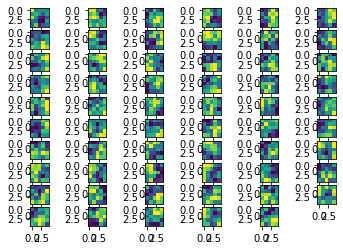

In [112]:
for i in range(1,60):
    plt.subplot(10,6,i)
    plt.imshow(test_filters[i])

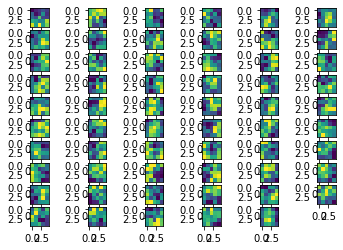

In [113]:
for i in range(1,60):
    plt.subplot(10,6,i)
    plt.imshow(test_filters[i+59])

<h3>Customised blocks</h3>

In [20]:
fashion_train_images = np.expand_dims(fashion_train_images, 3)
fashion_test_images = np.expand_dims(fashion_test_images,3)
fashion_train_images.shape

(60000, 28, 28, 1)

In [31]:
class testBlock(tf.keras.Model):
    def __init__(self, labels, filters, rec_field):
        super(testBlock, self).__init__()
        
        self.conv_1 = tf.keras.layers.Convolution2D(filters, rec_field, padding='same', use_bias=True, activation='tanh')
        self.conv_2 = tf.keras.layers.Convolution2D(filters, rec_field, padding='same', use_bias=True, activation='tanh')
        self.conv_3 = tf.keras.layers.Convolution2D(filters, rec_field, padding='same', use_bias=True, activation='tanh')
        self.collate = tf.keras.layers.Dense(labels, activation='softmax')
        
    def call(self, input_tensor):
        out_base = self.conv_1(input_tensor)
        out = self.conv_2(out_base)
        out = tf.raw_ops.Concat(concat_dim=3, values=[out, out_base]) # skip connection
        out = self.conv_3(out)
        out = tf.keras.layers.MaxPool2D(strides=(2,2))(out)
        out = tf.keras.layers.Flatten()(out)
        out = self.collate(out)
        return out       

In [32]:
testModel = testBlock(10, 32, 3)

testModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
testModel.fit(fashion_train_images, fashion_train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 120s 64ms/step - loss: 0.3320 - accuracy: 0.8839
Epoch 2/3
1875/1875 [==============================] - 153s 82ms/step - loss: 0.2691 - accuracy: 0.9056
Epoch 3/3
1875/1875 [==============================] - 219s 117ms/step - loss: 0.2384 - accuracy: 0.9151


In [35]:
testModel.evaluate(fashion_test_images,  fashion_test_labels, verbose=2)

313/313 - 11s - loss: 0.3085 - accuracy: 0.8887 - 11s/epoch - 34ms/step


[0.3084518611431122, 0.888700008392334]

In [36]:
testModel.summary()

Model: "test_block_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          multiple                  320       
                                                                 
 conv2d_16 (Conv2D)          multiple                  9248      
                                                                 
 conv2d_17 (Conv2D)          multiple                  18464     
                                                                 
 dense_5 (Dense)             multiple                  62730     
                                                                 
Total params: 90,762
Trainable params: 90,762
Non-trainable params: 0
_________________________________________________________________
